# 필요한 모듈 import

In [73]:
#드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [75]:
# 패키지 설치
!pip install kiwipiepy #형태소분석기
!pip install tomotopy #LDA 설계용
import pandas as pd #xlsx파일 불러오기 위한 pandas
import numpy as np
import datetime as dt #날짜 자료형 패키지
import matplotlib.pyplot as plt
import seaborn as sns
import re #정규표현식
import random #랜덤함수
import tomotopy as tp #tomotopy
import collections #counter 호출용
from math import sqrt #제곱근 계산
from tqdm import tqdm
tqdm.pandas() #진행상황 확인
from kiwipiepy import Kiwi #키위
from matplotlib import font_manager, rc #시각화 폰트 패키지
from wordcloud import WordCloud,STOPWORDS #워드클라우드 패키지
from PIL import Image #이미지 배경 패키지

In [76]:
from konlpy.tag import Mecab
mecab = Mecab()
print(mecab.morphs("사과와 바나나 그리고 포도를 좋아합니다"))

['사과', '와', '바나나', '그리고', '포도', '를', '좋아합니다']


# 데이터 불러오기



---

1. 제목 중복의 경우, 가장 높은 조회수를 가진 영상만을 남겨두고 모두 제거.
2. 정규 분포 함수로 집중적으로 업로드가 발생했던 시점만 추출


In [77]:
#news_all=pd.read_csv('/content/drive/MyDrive/2023 겨울계절 URP/데이터_수집/N번방_네이버뉴스.csv',index_col=0) #저장된 파일 불러오기
#news_all=pd.read_csv('/content/drive/MyDrive/2023 겨울계절 URP/데이터_수집/N번방 유튜브/N번방_youtube_data_No News.csv',index_col=0)
news_all=pd.read_csv('/content/drive/MyDrive/2023 겨울계절 URP/데이터_수집/원숭이두창 유튜브/원숭이두창_youtube_data_No News.csv',index_col=0)
news_all = news_all.rename(columns={'Title': '제목'})



In [78]:
news_all.reset_index(inplace=True)



---

유튜브 크롤링 결과에서 같은 제목을 가지고 있지만 조회수가 다른 영상들이 추출됨.
가장 높은 조회수를 가진 영상만을 남겨두고 모두 제거.

In [79]:
# Sort DataFrame by 'Views' in descending order
df_sorted = news_all.sort_values(by='Views', ascending=False)

# Drop duplicates based on '제목' while keeping the first occurrence (highest Views)
news_all = df_sorted.drop_duplicates(subset='제목', keep='first')


In [80]:
#파일 확인
news_all.head()

,Upload Date,Youtuber,제목,Views
1870,2019-04-30,Toystar TV,Hellocarbot Tobot Miniforce 32 sets car robot ...,28228505
1694,2023-08-31,사우스 코리안 파크 South Korean Park,The AC,5895498
838,2020-06-26,14F 일사에프,배고프면 난폭해지는 건 사람이나 원숭이나 똑같구나... ㅠ / 14F,5007523
1529,2023-03-03,pharmacist's supplements story,암이 자라나기 시작할때 우리 몸이 보내는 '암의 위험신호 5가지' 가 있습니다 (대...,4545581
1749,2018-09-04,[HoneyBee Tube] 꿀벌튜브,Hello Carbot Toys Dinosaur transformer robot T...,4283690


In [81]:
news_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1765 entries, 1870 to 1269
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Upload Date  1765 non-null   object
 1   Youtuber     1765 non-null   object
 2   제목           1765 non-null   object
 3   Views        1765 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 68.9+ KB


#views, 댓글 수 확인

<ipython-input-127-c7ac2c8a8d68>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Upload Date'] = pd.to_datetime(df['Upload Date'])
<ipython-input-127-c7ac2c8a8d68>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Views'] = df['Views'].astype(int)


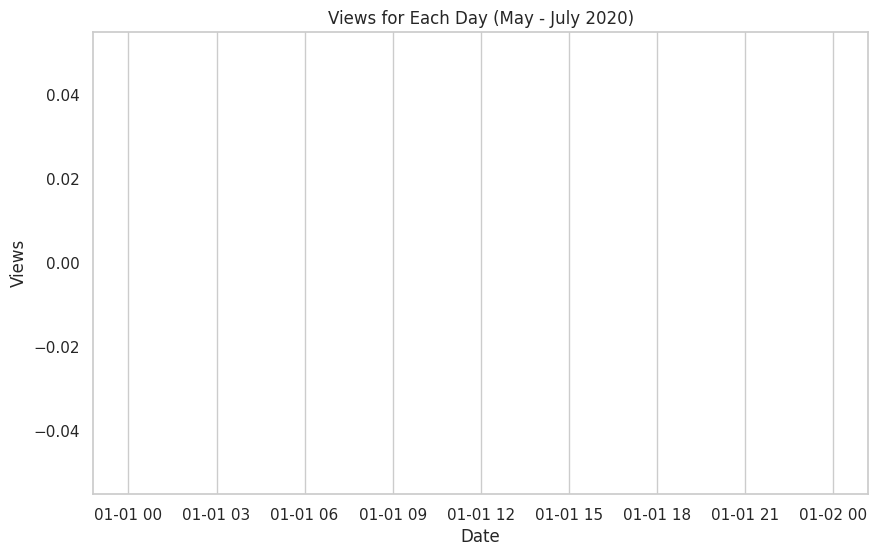

In [127]:
df = news_all
df['Upload Date'] = pd.to_datetime(df['Upload Date'])

# Filter the DataFrame for May, June, and July 2020
df['Views'] = df['Views'].astype(int)
df_filtered = df[(df['Upload Date'] >= '2020-05-01') & (df['Upload Date'] <= '2020-07-31')]


# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df_filtered['Upload Date'], df_filtered['Views'], color='skyblue')
plt.title('Views for Each Day (May - July 2020)')
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(axis='y')
plt.show()

## 정규분포함수

<ipython-input-82-9a171fa4e467>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Upload Date'] = pd.to_datetime(data['Upload Date'])
<ipython-input-82-9a171fa4e467>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = data['Upload Date'].dt.year
<ipython-input-82-9a171fa4e467>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

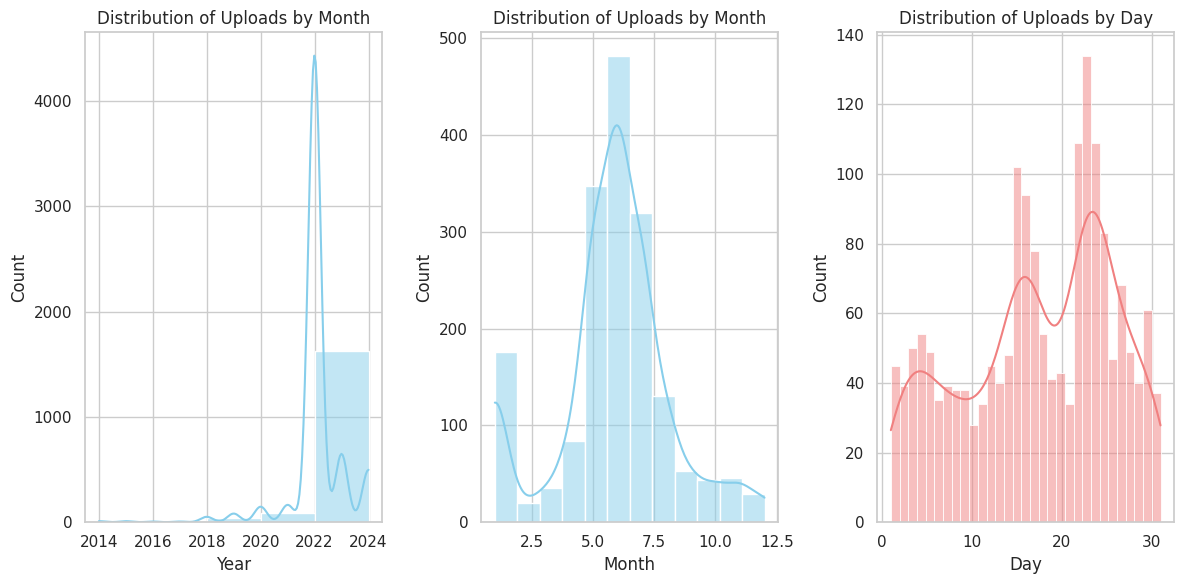

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Your data
data = news_all
# Convert 'Upload Date' to datetime format
data['Upload Date'] = pd.to_datetime(data['Upload Date'])

# Create a new column for month and day
data['Year'] = data['Upload Date'].dt.year
data['Month'] = data['Upload Date'].dt.month
data['Day'] = data['Upload Date'].dt.day

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

#연도별

plt.subplot(1, 3, 1)
sns.histplot(data['Year'], kde=True, bins=5, color='skyblue')
plt.title('Distribution of Uploads by Month')

# 월별
plt.subplot(1, 3, 2)
sns.histplot(data['Month'], kde=True, bins=12, color='skyblue')
plt.title('Distribution of Uploads by Month')

# 일별
plt.subplot(1, 3, 3)
sns.histplot(data['Day'], kde=True, bins=31, color='lightcoral')
plt.title('Distribution of Uploads by Day')

plt.tight_layout()
plt.show()


<ipython-input-83-2e8690a6bfec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Upload Date'] = pd.to_datetime(data['Upload Date'])
<ipython-input-83-2e8690a6bfec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = data['Upload Date'].dt.year
<ipython-input-83-2e8690a6bfec>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

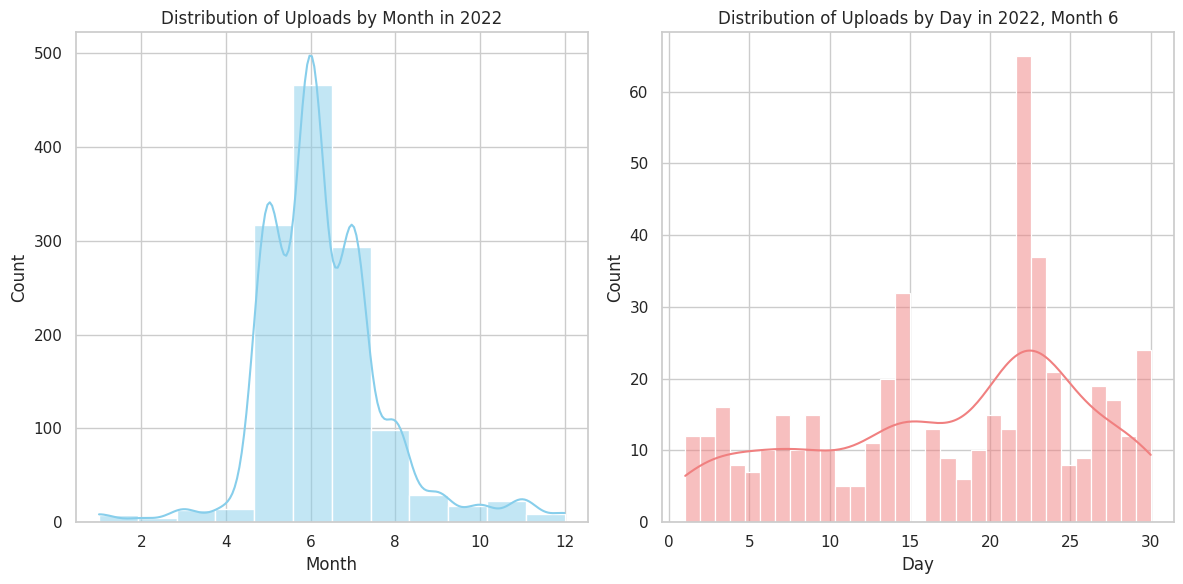

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Your data
data = news_all

# Convert 'Upload Date' to datetime format
data['Upload Date'] = pd.to_datetime(data['Upload Date'])

# Extract year, month, and day
data['Year'] = data['Upload Date'].dt.year
data['Month'] = data['Upload Date'].dt.month
data['Day'] = data['Upload Date'].dt.day

# Find the year with the highest concentration of uploads
most_common_year = data['Year'].mode().iloc[0]

# Filter data for the most common year
most_common_year_data = data[data['Year'] == most_common_year]

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Distribution of uploads by month for the most common year
plt.subplot(1, 2, 1)
sns.histplot(most_common_year_data['Month'], kde=True, bins=12, color='skyblue')
plt.title(f'Distribution of Uploads by Month in {most_common_year}')

# Distribution of uploads by day for the most common year and month
most_common_month = most_common_year_data['Month'].mode().iloc[0]
most_common_month_data = most_common_year_data[most_common_year_data['Month'] == most_common_month]

plt.subplot(1, 2, 2)
sns.histplot(most_common_month_data['Day'], kde=True, bins=31, color='lightcoral')
plt.title(f'Distribution of Uploads by Day in {most_common_year}, Month {most_common_month}')

plt.tight_layout()
plt.show()


In [84]:
print('most_common_year : ', most_common_year)
print('most_common_month : ', most_common_month)

most_common_year :  2022
most_common_month :  6


## most_common_year 행만 추출

In [85]:
# Convert 'Upload Date' to datetime format
data['Upload Date'] = pd.to_datetime(data['Upload Date'])

# Extract year, month, and day
data['Year'] = data['Upload Date'].dt.year

# Find the year with the highest concentration of uploads
most_common_year = data['Year'].mode().iloc[0]

# Extract rows corresponding to the most common year
#유튜브 n번방
#most_common_year_data = data[(data['Year'] == most_common_year) & ((data['Month'] == 3)|(data['Month'] == 4)|(data['Month'] == 5))]

#유튜브 원숭이두창
most_common_year_data = data[(data['Year'] == most_common_year) & ((data['Month'] == 5)|(data['Month'] == 6)|(data['Month'] == 7))]
#most_common_year_data = data[(data['Year'] == most_common_year) & ((data['Month'] == 5)|(data['Month'] == 6)|(data['Month'] == 7)|(data['Month'] == 8))]
#most_common_year_data = data[(data['Year'] == most_common_year) & (data['Month'] == 6)]
print(most_common_year_data)

     Upload Date        Youtuber  \
1360  2022-07-25       사피엔스 스튜디오   
1352  2022-06-16            슈카월드   
494   2022-05-23        VIDEOMUG   
1351  2022-06-26   DOCTORFRIENDS   
1511  2022-07-09          퍄퍄킴 역사   
...          ...             ...   
520   2022-06-23  Hassan Ibrahim   
197   2022-06-27         여의도 백프로   
1190  2022-05-24  주식투자는 여의도 해병개미   
1153  2022-07-14  주식투자는 여의도 해병개미   
1269  2022-07-20       최주식맞춤주식특강   

                                                     제목    Views  Year  Month  \
1360  이번에는 원숭이두창이 유행? 몸에서 보내는 면역력 주의보, 가려움증에 대한 모든 것...  1102048  2022      7   
1352                              원숭이두창, WHO 보건 비상사태 선포  1013820  2022      6   
494   전 세계 퍼지는 '원숭이 두창'…얼마나 위험? 대유행 가능성은? (ft.조동찬 의학...   828034  2022      5   
1351  First case of Monkeypox in Korea! What are the...   692310  2022      6   
1511                            인류는 이 미친 질병을 어떻게 극복했을까?   614285  2022      7   
...                                                 ...      ...   ...    ...   


<ipython-input-85-0c666bc97382>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Upload Date'] = pd.to_datetime(data['Upload Date'])
<ipython-input-85-0c666bc97382>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = data['Upload Date'].dt.year


In [86]:
print(most_common_year_data)

     Upload Date        Youtuber  \
1360  2022-07-25       사피엔스 스튜디오   
1352  2022-06-16            슈카월드   
494   2022-05-23        VIDEOMUG   
1351  2022-06-26   DOCTORFRIENDS   
1511  2022-07-09          퍄퍄킴 역사   
...          ...             ...   
520   2022-06-23  Hassan Ibrahim   
197   2022-06-27         여의도 백프로   
1190  2022-05-24  주식투자는 여의도 해병개미   
1153  2022-07-14  주식투자는 여의도 해병개미   
1269  2022-07-20       최주식맞춤주식특강   

                                                     제목    Views  Year  Month  \
1360  이번에는 원숭이두창이 유행? 몸에서 보내는 면역력 주의보, 가려움증에 대한 모든 것...  1102048  2022      7   
1352                              원숭이두창, WHO 보건 비상사태 선포  1013820  2022      6   
494   전 세계 퍼지는 '원숭이 두창'…얼마나 위험? 대유행 가능성은? (ft.조동찬 의학...   828034  2022      5   
1351  First case of Monkeypox in Korea! What are the...   692310  2022      6   
1511                            인류는 이 미친 질병을 어떻게 극복했을까?   614285  2022      7   
...                                                 ...      ...   ...    ...   


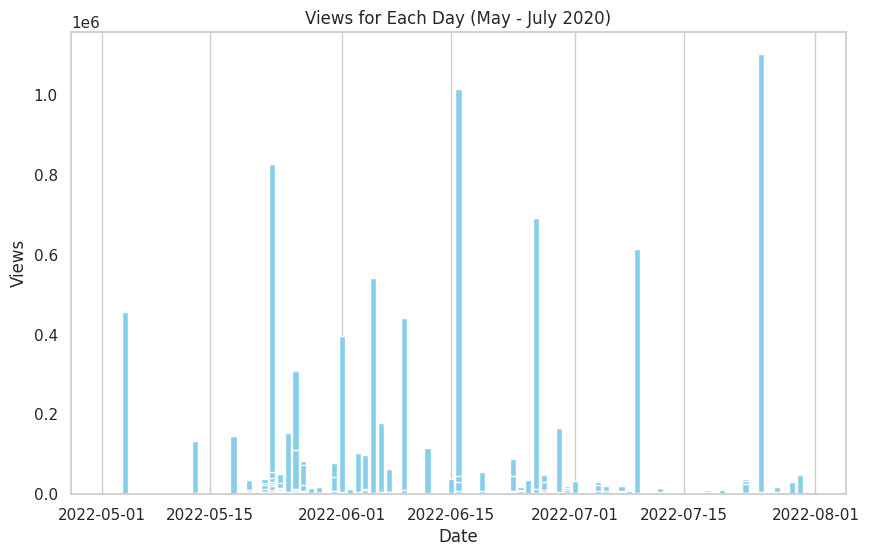

In [129]:
df = most_common_year_data



# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df['Upload Date'], df['Views'], color='skyblue')
plt.title('Views for Each Day (May - July 2020)')
plt.xlabel('Date')
plt.ylabel('Views')
plt.grid(axis='y')
plt.show()

In [87]:
#분석할 데이터 프레임 명을 news_all로 변경
news_all = most_common_year_data

# 전처리

## 명사추출

In [88]:
#형태소분석기 호출★
from kiwipiepy import Kiwi
kiwi = Kiwi()

In [89]:
#특수기호 제거
pattern1 = '[-=+,#/\?:;^$.A*"~%!\\\n\r\t<>[]{}()▼▽♣♧§☆♡´∀｀ﾉ♥♡▲△�ㅁ▼▽▶▷◀◁★☆♠♤●○◎⊙◆◇■□＊━▣“”]' #특수기호 목록
news_all['제목']=news_all['제목'].progress_map(lambda x:re.sub(pattern1, ' ', x).strip())  # 특수 기호를 " " 공란으로

100%|██████████| 1076/1076 [00:00<00:00, 94966.04it/s]
<ipython-input-89-caa9287a7c7e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_all['제목']=news_all['제목'].progress_map(lambda x:re.sub(pattern1, ' ', x).strip())  # 특수 기호를 " " 공란으로


In [90]:
kiwi.analyze('금잔디에 가면 볶음우동을 먹을 수 있어요')

[([Token(form='금잔디', tag='NNP', start=0, len=3),
   Token(form='에', tag='JKB', start=3, len=1),
   Token(form='가', tag='VV', start=5, len=1),
   Token(form='면', tag='EC', start=6, len=1),
   Token(form='볶음', tag='NNG', start=8, len=2),
   Token(form='우동', tag='NNG', start=10, len=2),
   Token(form='을', tag='JKO', start=12, len=1),
   Token(form='먹', tag='VV', start=14, len=1),
   Token(form='을', tag='ETM', start=15, len=1),
   Token(form='수', tag='NNB', start=17, len=1),
   Token(form='있', tag='VA', start=19, len=1),
   Token(form='어요', tag='EF', start=20, len=2)],
  -68.07340240478516)]

In [91]:
 #명사 추출 함수 (kiwi 0.10.0)
 def get_noun(texts):
    res = kiwi.analyze(texts)[0][0]
    return [Token[0]
            for Token in res
            if Token[1]=='NNG' or Token[1]=='NNP']

#함수 동작 체크
get_noun('금잔디에 가면 볶음우동을 먹을 수 있어요')

['금잔디', '볶음', '우동']

**부가설명**

Kiwi는 List[Tuple[List[Tuple[형태소, 품사태그, 시작위치, 문자열길이]], 분석 점수]] 형태로 분석 결과를 출력합니다.

맨 바깥 리스트에서 res라는 변수를 생성하고(Line 2), 이를 활용하여 품사 태그가 NNG(명사) 혹은 NNP(고유명사)인 형태소만을 리스트 형태로 반환합니다(Line 3~5).

참고로 Kiwi의 품사 태그는 Sejong의 것과 동일합니다.

In [92]:
# 최초 형태소 분석★
# 전처리 후 다시 형태소분석을 진행할 때도 이 셀을 실행해주세요.
news_all['nouns'] = news_all['제목'].progress_map(lambda x:get_noun(x))

100%|██████████| 1076/1076 [00:03<00:00, 340.19it/s]
<ipython-input-92-d06654356769>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_all['nouns'] = news_all['제목'].progress_map(lambda x:get_noun(x))


In [93]:
#결과 확인
news_all.head()

,Upload Date,Youtuber,제목,Views,Year,Month,Day,nouns
1360,2022-07-25,사피엔스 스튜디오,"이번에는 원숭이두창이 유행? 몸에서 보내는 면역력 주의보, 가려움증에 대한 모든 것...",1102048,2022,7,25,"[이번, 원숭이, 창, 유행, 몸, 면역력, 주의보, 가려움증, 서재, 걸, 면역,..."
1352,2022-06-16,슈카월드,"원숭이두창, WHO 보건 비상사태 선포",1013820,2022,6,16,"[원숭이, 창, 비상사태, 선포]"
494,2022-05-23,VIDEOMUG,전 세계 퍼지는 '원숭이 두창'…얼마나 위험? 대유행 가능성은? (ft.조동찬 의학...,828034,2022,5,23,"[세계, 원숭이, 창, 위험, 유행, 가능, 조동찬, 의학전문기자, 비머, 비디오머그]"
1351,2022-06-26,DOCTORFRIENDS,First case of Monkeypox in Korea! What are the...,692310,2022,6,26,[]
1511,2022-07-09,퍄퍄킴 역사,인류는 이 미친 질병을 어떻게 극복했을까?,614285,2022,7,9,"[인류, 질병, 극복]"


In [94]:
news_all['nouns']

1360    [이번, 원숭이, 창, 유행, 몸, 면역력, 주의보, 가려움증, 서재, 걸, 면역,...
1352                                   [원숭이, 창, 비상사태, 선포]
494      [세계, 원숭이, 창, 위험, 유행, 가능, 조동찬, 의학전문기자, 비머, 비디오머그]
1351                                                   []
1511                                         [인류, 질병, 극복]
                              ...                        
520                      [원숭이, 창, 유행, 가능, 전파, 우려, 케이팝, 신]
197                                 [미코바이오메드, 원숭이, 창, 시작]
1190          [해병, 개미, 진원생명과학, 원숭이, 창, 테마, 형성, 대장, 주, 등극]
1153                             [해병, 개미, 한국, 비엔, 정보, 매수]
1269                          [진원생명과학, 오늘, 최, 주식, 맞춤, 특강]
Name: nouns, Length: 1076, dtype: object



> 전처리 반복


다음 과정을 아주 많이 반복합니다:

1. 일부 아이템을 랜덤하게 추출하여 확인
1.   정규화
2.   커스텀 사전 추가
3.   불용어 제거
4.   다시 형태소분석
















**기사 랜덤 추출**

## 커스텀사전

In [95]:
#카운터 리셋
counter=0

In [96]:
i = random.randint(0, len(news_all))

print("article {}".format(i)) #인덱스 번호
print(news_all.iloc[i][['제목','nouns']].values[0]) #기사 본문
print(news_all.iloc[i][['제목','nouns']].values[1]) #생성된 토큰
counter+=1


print('counter:{}'.format(counter))

article 191
트랜스젠더 헤어디자이너 손님 계속 왔어요.. 점심 먹자
['트랜스젠더', '헤어', '디자이너', '손님', '점심']
counter:1


In [97]:

#원숭이두창
word_list=['원숭이두창','동성애','녹십자엠에스','광끼광풍','마약','바이오주식','서류미비자','차백신연구소','진매트릭스','동구바이오제약','CMG제약','일양약품우','녹십자홀딩스','진매트릭스','동구바이오','차백신연구소','녹십자엠에스','해병개미','FDA','우리나라','HK이노엔','블루베리NFT','관련주','상한가','동성애','한국비엔씨','우주항공','질병청','SK바이오사이언스',\
           '반등','신풍제약','한국콜마홀딩스','애플카','의학한림원','대봉엘에스','승일','과기한림원','어닝서프라이즈','에이스토리','우영우','신풍제약',\

]

In [98]:
# Remove duplicates while preserving the order
unique_word_list = list(dict.fromkeys(word_list))

# Print the result
print(unique_word_list)

['원숭이두창', '동성애', '녹십자엠에스', '광끼광풍', '마약', '바이오주식', '서류미비자', '차백신연구소', '진매트릭스', '동구바이오제약', 'CMG제약', '일양약품우', '녹십자홀딩스', '동구바이오', '해병개미', 'FDA', '우리나라', 'HK이노엔', '블루베리NFT', '관련주', '상한가', '한국비엔씨', '우주항공', '질병청', 'SK바이오사이언스', '반등', '신풍제약', '한국콜마홀딩스', '애플카', '의학한림원', '대봉엘에스', '승일', '과기한림원', '어닝서프라이즈', '에이스토리', '우영우']


In [99]:
#커스텀 사전 리스트를 dataframe형태로 변환
custom_dict = pd.DataFrame({"word":unique_word_list})

#품사태그는 고유명사로 지정
custom_dict['morp']="NNP"

#Kiwi는 우선순위를 부여하기 위해 score개념이 존재합니다. 커스텀 단어를 우선 활용하기 위해 score값에 1을 부여.
custom_dict['score']=1

#데이터 확인
custom_dict.head()

,word,morp,score
0,원숭이두창,NNP,1
1,동성애,NNP,1
2,녹십자엠에스,NNP,1
3,광끼광풍,NNP,1
4,마약,NNP,1


In [100]:
#커스텀 사전을 csv로 저장하고 불러옴★
custom_dict.to_csv("/content/drive/MyDrive/2023 겨울계절 URP/데이터_수집/custom_dict.txt", index=False, header=False, sep="\t",encoding='UTF-8')

In [101]:
#kiwi의 load_user_dictionary는 커스텀 사전을 변경할 경우 업데이트된 단어의 수를 반환해 줍니다.
kiwi.load_user_dictionary('/content/drive/MyDrive/2023 겨울계절 URP/데이터_수집/custom_dict.txt')

36

In [102]:
# 최초 형태소 분석★
# 전처리 후 다시 형태소분석을 진행할 때도 이 셀을 실행해주세요.
news_all['nouns'] = news_all['제목'].progress_map(lambda x:get_noun(x))

100%|██████████| 1076/1076 [00:07<00:00, 142.81it/s]
<ipython-input-102-d06654356769>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_all['nouns'] = news_all['제목'].progress_map(lambda x:get_noun(x))


## **단어정규화 딕셔너리**

In [103]:
#카운터 리셋
counter=0

In [104]:
i = random.randint(0, len(news_all))

print("article {}".format(i)) #인덱스 번호
print(news_all.iloc[i][['제목','nouns']].values[0]) #기사 본문
print(news_all.iloc[i][['제목','nouns']].values[1]) #생성된 토큰
counter+=1
print('counter:{}'.format(counter))

article 220
신풍제약 (019170) - 그래 원숭이두창 하자!!!
['신풍제약', '원숭이두창']
counter:1


* 정규화: 동일한 표현을 다르게 쓴 것을 모두 통일해주는 것
영어 약자, 유행병 이름, 사람 이름, 한자 및 영어 표현 등 수작업으로 교체하여 분류 정확도 높이기

In [105]:
#정규화 딕셔너리 ★
dic_standardization={'ㅁr약':'마약','두창':'원숭이두창','동성':'동성애',\


    '法':'법원','비디오머그':'방송','X착취':'성착취','마지막화':'방송','영화':'방송','다큐':'방송','넷플릭스':'방송','알쓸범잡':'방송','미성년':'미성년자','김원사건파일':'방송','스타':'연예인','엑소':"연예인",'찬열':'연예인','백현':'연예인','유사':'제2','재발':'제2','국민':'국민청원',\
                     '문':'문재인','남성':'남자','檢·警':'검·경','성착취범':'성착취','제2의':'제2','붓다':'부따','그알':"방송",\
                     '박사':'박사방','男':'남자','신상':'신상공개','공개':'신상공개','性':'성','代':'대','부대':'군대','육군':'군대','일병':'군대',\
                     '디지털성범죄':'디지털성범죄물','디지털':'디지털성범죄물','성착취물':'성착취','착취물':'성착취','中':'중국','靑':'청와대','文':'문재인','★':'연예인','무기징역형':'무기징역','女':'여자',\
                     '그알':'그것이알고싶다','n번방':'N번방','軍':'군','檢':'검사','韓':'한국','與':'여당','野':'야당','北':'북한','(脫)':'','(非)':'','(正常)':''}

In [106]:
#정규화 딕셔너리를 활용하여 단어 교체★
for old, new in dic_standardization.items():
  print("convert {} into {}.".format (old, new))
  news_all['제목'] = news_all['제목'].progress_map(lambda x:x.replace(old, new))

convert ㅁr약 into 마약.


100%|██████████| 1076/1076 [00:00<00:00, 65996.01it/s]
<ipython-input-106-3c8aafef5074>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_all['제목'] = news_all['제목'].progress_map(lambda x:x.replace(old, new))


convert 두창 into 원숭이두창.


100%|██████████| 1076/1076 [00:00<00:00, 258096.25it/s]


convert 동성 into 동성애.


100%|██████████| 1076/1076 [00:00<00:00, 272396.86it/s]


convert 法 into 법원.


100%|██████████| 1076/1076 [00:00<00:00, 258066.74it/s]


convert 비디오머그 into 방송.


100%|██████████| 1076/1076 [00:00<00:00, 308881.74it/s]


convert X착취 into 성착취.


100%|██████████| 1076/1076 [00:00<00:00, 285186.17it/s]


convert 마지막화 into 방송.


100%|██████████| 1076/1076 [00:00<00:00, 294779.30it/s]


convert 영화 into 방송.


100%|██████████| 1076/1076 [00:00<00:00, 282632.21it/s]


convert 다큐 into 방송.


100%|██████████| 1076/1076 [00:00<00:00, 349823.36it/s]


convert 넷플릭스 into 방송.


100%|██████████| 1076/1076 [00:00<00:00, 375463.49it/s]


convert 알쓸범잡 into 방송.


100%|██████████| 1076/1076 [00:00<00:00, 373135.27it/s]


convert 미성년 into 미성년자.


100%|██████████| 1076/1076 [00:00<00:00, 329325.10it/s]


convert 김원사건파일 into 방송.


100%|██████████| 1076/1076 [00:00<00:00, 375995.26it/s]


convert 스타 into 연예인.


100%|██████████| 1076/1076 [00:00<00:00, 342080.73it/s]


convert 엑소 into 연예인.


100%|██████████| 1076/1076 [00:00<00:00, 364810.53it/s]


convert 찬열 into 연예인.


100%|██████████| 1076/1076 [00:00<00:00, 157134.89it/s]


convert 백현 into 연예인.


100%|██████████| 1076/1076 [00:00<00:00, 330724.84it/s]


convert 유사 into 제2.


100%|██████████| 1076/1076 [00:00<00:00, 185608.52it/s]


convert 재발 into 제2.


100%|██████████| 1076/1076 [00:00<00:00, 305515.24it/s]


convert 국민 into 국민청원.


100%|██████████| 1076/1076 [00:00<00:00, 126342.24it/s]


convert 문 into 문재인.


100%|██████████| 1076/1076 [00:00<00:00, 361334.76it/s]


convert 남성 into 남자.


100%|██████████| 1076/1076 [00:00<00:00, 319464.22it/s]


convert 檢·警 into 검·경.


100%|██████████| 1076/1076 [00:00<00:00, 331331.85it/s]


convert 성착취범 into 성착취.


100%|██████████| 1076/1076 [00:00<00:00, 314324.50it/s]


convert 제2의 into 제2.


100%|██████████| 1076/1076 [00:00<00:00, 343591.25it/s]


convert 붓다 into 부따.


100%|██████████| 1076/1076 [00:00<00:00, 347426.57it/s]


convert 그알 into 그것이알고싶다.


100%|██████████| 1076/1076 [00:00<00:00, 324587.97it/s]


convert 박사 into 박사방.


100%|██████████| 1076/1076 [00:00<00:00, 346865.81it/s]


convert 男 into 남자.


100%|██████████| 1076/1076 [00:00<00:00, 267536.37it/s]


convert 신상 into 신상공개.


100%|██████████| 1076/1076 [00:00<00:00, 352061.09it/s]


convert 공개 into 신상공개.


100%|██████████| 1076/1076 [00:00<00:00, 386260.79it/s]


convert 性 into 성.


100%|██████████| 1076/1076 [00:00<00:00, 101764.93it/s]


convert 代 into 대.


100%|██████████| 1076/1076 [00:00<00:00, 345882.21it/s]


convert 부대 into 군대.


100%|██████████| 1076/1076 [00:00<00:00, 337577.31it/s]


convert 육군 into 군대.


100%|██████████| 1076/1076 [00:00<00:00, 467772.71it/s]


convert 일병 into 군대.


100%|██████████| 1076/1076 [00:00<00:00, 469866.85it/s]


convert 디지털성범죄 into 디지털성범죄물.


100%|██████████| 1076/1076 [00:00<00:00, 373970.09it/s]


convert 디지털 into 디지털성범죄물.


100%|██████████| 1076/1076 [00:00<00:00, 369893.54it/s]


convert 성착취물 into 성착취.


100%|██████████| 1076/1076 [00:00<00:00, 377694.46it/s]


convert 착취물 into 성착취.


100%|██████████| 1076/1076 [00:00<00:00, 223198.37it/s]


convert 中 into 중국.


100%|██████████| 1076/1076 [00:00<00:00, 264370.63it/s]


convert 靑 into 청와대.


100%|██████████| 1076/1076 [00:00<00:00, 381042.82it/s]


convert 文 into 문재인.


100%|██████████| 1076/1076 [00:00<00:00, 302890.68it/s]


convert ★ into 연예인.


100%|██████████| 1076/1076 [00:00<00:00, 403854.24it/s]


convert 무기징역형 into 무기징역.


100%|██████████| 1076/1076 [00:00<00:00, 378200.88it/s]


convert 女 into 여자.


100%|██████████| 1076/1076 [00:00<00:00, 122491.34it/s]


convert n번방 into N번방.


100%|██████████| 1076/1076 [00:00<00:00, 313407.72it/s]


convert 軍 into 군.


100%|██████████| 1076/1076 [00:00<00:00, 250184.11it/s]


convert 檢 into 검사.


100%|██████████| 1076/1076 [00:00<00:00, 217991.17it/s]


convert 韓 into 한국.


100%|██████████| 1076/1076 [00:00<00:00, 370561.71it/s]


convert 與 into 여당.


100%|██████████| 1076/1076 [00:00<00:00, 378074.15it/s]


convert 野 into 야당.


100%|██████████| 1076/1076 [00:00<00:00, 259700.26it/s]


convert 北 into 북한.


100%|██████████| 1076/1076 [00:00<00:00, 300490.79it/s]


convert (脫) into .


100%|██████████| 1076/1076 [00:00<00:00, 356679.93it/s]


convert (非) into .


100%|██████████| 1076/1076 [00:00<00:00, 383634.06it/s]


convert (正常) into .


100%|██████████| 1076/1076 [00:00<00:00, 373073.58it/s]


## **불용어 제거**


---


불용어는 분석에 사용되지 않을 단어를 의미합니다. 다음 유형의 단어를 제거하였습니다:

1. 자연어처리 시 통용되는 불용어 리스트
2. 너무 많이 등장하는 단어들 - 모든 문서에서 공통적으로 등장하여 분류 성능을 낮출 우려가 있음.
한 단어로 된 단어
3. 토픽 특성상 핵심 주제어인 '원전' '원자력발전'도 제거하는 게 좋음

In [107]:
#1차 필터링: 한국어 불용어 사전 활용★
stop_list1 = open('/content/drive/MyDrive/2023 겨울계절 URP/코드/재희/토픽모델링/stopword.txt', encoding = 'utf-8')


lines1 = stop_list1.readlines() #한 줄마다 읽어옴


stopwords = [] #불용어 리스트
for line in lines1:
    a= line.split() #줄 단위 분할
    stopwords.append(a) #한 줄마다 불용어 리스트에 추가


In [108]:
i = random.randint(0, len(news_all))

print("article {}".format(i)) #인덱스 번호
print(news_all.iloc[i][['제목','nouns']].values[0]) #기사 본문
print(news_all.iloc[i][['제목','nouns']].values[1]) #생성된 토큰
counter+=1
print('counter:{}'.format(counter))

article 126
尹, 한달만에 데드크로스? 긍정보다 부정 높다! 원숭이 원숭이두창 감염 경로도 파악 할 수 없다고? 경제포기, 전염병 전파 시민 탓? 안 봐도 뻔한 스토리!
['데드', '크로스', '긍정', '부정', '원숭이', '창', '감염', '경로', '파악', '경제', '포기', '전염병', '전파', '시민', '탓', '스토리']
counter:2


In [109]:
#2차 필터링: 커스텀 불용어 리스트★
custom_stopwords = ['노터스','원숭이','원숭이두창','반도체','셀트리온','켐온','LG전자','매일경제TV','에스피시스템스','위메이드맥스','지투파워','티플랙스','나노젠',\
                    '에이프로젠','오상자이엘','큐로컴','우주','아남전자','두산에너빌리티','엠폭스','엑세스바이오','가온칩스','아미노로직스','네온테크','인베스트먼트' ,\
                    '뉴스큐','일양약품우','녹십자홀딩스','차백신연구소','진매트릭스','동구바이오','해병개미','녹십자엠에스','휴마시스', '수젠텍', '예상', '하락','우주항공', '현대차','진원생명과학', '단타' ,\
                    '글로벌','나우','크랩','씨젠','현대','신풍제약','미코바이오메드','파미셀','엠에스','SK바이오사이언스','에너지', '에이스토리', '더블', '바른', '경제', '라이브','한국콜마홀딩스','애플카','의학한림원','대봉엘에스','승일','과기한림원','어닝서프라이즈','에이스토리','한국비엔씨','톡톡','강희성', '바이오','HK이노엔','블루베리NFT', '메가트렌드','현장','공유','중심','시선','무플방지','취재','사건','강력','사설','브리핑','오디오래빗','양성희','취중','이동','정면','승부','논설위원','확대경','한마당','마당','통과','밑줄','처리','가능','심층','현장','연결','인터뷰','속보','이데일리','대상','발언','관련','영상','황출새','타임라인','착취','뉴스','핫클릭','보도자료','뉴스하이킥','종합','사사건건','영상','지금','단독','이번','뉴구세요','포토','오늘','물','뉴스큐','이슈와치','단독','초점','이슈','관련','한국','이날','발생','이후','이번','오후','오전','가운데','기자','사진','최근','정부','나이트포커스','정승민']
stopwords+=custom_stopwords #커스텀 불용어를 리스트에 추가

In [110]:
#'불용어 리스트에 없는'형태소만 남기는 방식으로 불용어 제거★
news_all['nouns'] = news_all['nouns'].progress_map(lambda x:[w for w in x if w not in stopwords])

100%|██████████| 1076/1076 [00:00<00:00, 1822.30it/s]
<ipython-input-110-0724f6fa9bb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_all['nouns'] = news_all['nouns'].progress_map(lambda x:[w for w in x if w not in stopwords])


In [111]:
#3차 필터링: 한 글자 제거★
news_all['nouns'] = news_all['nouns'].progress_map(lambda x:[w for w in x if len(w) > 1])

100%|██████████| 1076/1076 [00:00<00:00, 124901.64it/s]
<ipython-input-111-128724ea1ca8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_all['nouns'] = news_all['nouns'].progress_map(lambda x:[w for w in x if len(w) > 1])


In [112]:
#print(news_all.iloc[3502][['제목','nouns']].values[1]) #기사 본문

In [113]:
news_all.head()

,Upload Date,Youtuber,제목,Views,Year,Month,Day,nouns
1360,2022-07-25,사피엔스 스튜디오,"이번에는 원숭이원숭이두창이 유행? 몸에서 보내는 면역력 주의보, 가려움증에 대한 모...",1102048,2022,7,25,"[유행, 면역력, 주의보, 가려움증, 서재, 면역, 내과]"
1352,2022-06-16,슈카월드,"원숭이원숭이두창, WHO 보건 비상사태 선포",1013820,2022,6,16,"[비상사태, 선포]"
494,2022-05-23,VIDEOMUG,전 세계 퍼지는 '원숭이 원숭이두창'…얼마나 위험? 대유행 가능성은? (ft.조동찬...,828034,2022,5,23,"[세계, 위험, 유행, 조동찬, 의학전문기자, 비머, 비디오머그]"
1351,2022-06-26,DOCTORFRIENDS,First case of Monkeypox in Korea! What are the...,692310,2022,6,26,[]
1511,2022-07-09,퍄퍄킴 역사,인류는 이 미친 질병을 어떻게 극복했을까?,614285,2022,7,9,"[인류, 질병, 극복]"


In [114]:
#단어 빈도 파악
nouncounter=news_all['nouns'].sum() #형태소 목록 병합
counts = collections.Counter(nouncounter) #병합된 목록 카운트
print(counts) #결과

Counter({'관련주': 202, '주가': 155, '주식': 140, '전망': 137, '분석': 87, '종목': 83, '백신': 74, '코로나': 69, '국내': 52, '확산': 49, '급등': 44, '동성애': 39, '테마': 39, '투자': 36, '증상': 35, '감염': 34, '진단': 34, '세계': 31, '바이러스': 29, '시황': 29, '상승': 26, '천연두': 25, '확진자': 25, '시장': 25, '제약': 24, '키트': 24, '질병': 23, '원전': 23, '이유': 21, '관심': 21, '비상사태': 20, '매매': 20, '예방': 19, '정리': 19, '대응': 19, '테마주': 19, '수익': 18, '치료제': 18, '증시': 18, '수혜주': 18, '차트': 18, '시작': 18, '매수': 18, '유행': 17, '재건': 17, '정보': 17, '특징': 17, '롤러코스터': 17, '삼성전자': 16, '방송': 16, '추천': 16, '대장': 16, '홀딩스': 16, '상한가': 16, '급등주': 16, '의심': 15, '미국': 15, '반대': 15, '체크': 15, '전염병': 14, '공개': 14, '사료': 14, '감염병': 14, '기초': 14, '원인': 13, '축제': 13, '반등': 13, '전략': 13, '초보': 13, '위험': 12, '퀴어': 12, '경로': 12, '팬데믹': 12, '산업': 12, '기계': 12, '건강': 12, '검토': 12, '실적': 12, '유럽': 12, '확인': 12, '급락': 12, '전염': 11, '해병': 11, '환자': 11, '주의': 11, '긴급': 11, '세력': 11, '수두': 11, '도입': 11, '에이치엘비': 11, '간염': 11, '확진': 11, '프로': 11, '바닥': 11, '시청': 11, '치료': 10, '

In [115]:
news_all['nouns']

1360        [유행, 면역력, 주의보, 가려움증, 서재, 면역, 내과]
1352                              [비상사태, 선포]
494     [세계, 위험, 유행, 조동찬, 의학전문기자, 비머, 비디오머그]
1351                                      []
1511                            [인류, 질병, 극복]
                        ...                 
520                        [유행, 전파, 우려, 케이팝]
197                                     [시작]
1190                        [테마, 형성, 대장, 등극]
1153                                [정보, 매수]
1269                            [주식, 맞춤, 특강]
Name: nouns, Length: 1076, dtype: object

In [116]:
processed_data=[]
df=news_all

# Iterate through the DataFrame
for index, row in df.iterrows():
    nouns_list = row['nouns']
    processed_data.append(nouns_list)


In [117]:
processed_data

[['유행', '면역력', '주의보', '가려움증', '서재', '면역', '내과'],
 ['비상사태', '선포'],
 ['세계', '위험', '유행', '조동찬', '의학전문기자', '비머', '비디오머그'],
 [],
 ['인류', '질병', '극복'],
 ['해병대', '자진', '입대', '심영'],
 ['키움', '다큐', '하루', '수익', '천재', '대학생', '스캘핑', '천재'],
 ['계속', '마스크', '지적', '관찰자', '시점', '최재천', '아마존', '생태', '백신', '바이러스'],
 ['세계', '전염'],
 ['의심'],
 ['성병', '증상', '병원'],
 ['해병', '영화', '해병', '햄스터', '추억'],
 ['요즘', '난리', '백신', '접종'],
 ['해병', '영화', '해병', '군사재판', '잔망', '기억'],
 ['유튜브', '강의', '처음'],
 ['미국', '음모', '동성애', '함익병', '진실'],
 ['동성', '성관계', '딱지'],
 ['아쎄', '희망'],
 ['아내', '아랍', '남자', '하루'],
 ['대한민국', '동물', '전쟁', '상처', '자연', '선물', '지적', '관찰자', '시점', '최재천', '전쟁'],
 ['해병', '문학', '해병', '국밥'],
 ['캐릭터', '풀버젼', '해병', '공군'],
 ['폭스', '확산', '폭스', '원인', '증상', '예방', '준비', '피부과', '전문의', '닥터', '피부'],
 ['물집', '피부', '질환', '함익병', '피부과', '함익병'],
 ['역사', '충격', '회견'],
 ['감염', '희귀병', '미스터리'],
 [],
 ['해병', '문학', '세계', '해병', '통합'],
 ['삼성전자', '문제', '영주', '소장'],
 ['긴장', '성소수자', '환자', '의학전문기자', '비머', '비디오머그'],
 ['크림반도', '부족', '사태'],
 ['공군'],
 ['

# LDA



```
# processed_data=[['스위트', '새벽', '시간'],
 ['스위트', '송강'],
 ['스위트', '스위트', '나용'],
 ['스위트'],
 ['스위트'],
 ['앞자리', ...
```



##필요한 모듈 import



In [118]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)




##모델링


* 📌 num_topics: 생성될 토픽의 개수
* 📌 chunksize: 한번의 트레이닝에 처리될 문서의 개수
* 📌 passes: 전체 코퍼스 트레이닝 횟수
* 📌 interations: 문서 당 반복 횟수

`class gensim.models.ldamodel.LdaModel(corpus=None, num_topics=100, id2word=None, distributed=False, chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, decay=0.5, offset=1.0, eval_every=10, iterations=50, gamma_threshold=0.001, minimum_probability=0.01, random_state=None, ns_conf=None, minimum_phi_value=0.01, per_word_topics=False, callbacks=None, dtype=<class 'numpy.float32'>)`

물론 이 파라미터를 다른 숫자로 여러번 해서 가장 정확도 높은 모델을 선택하는 것이 가장 좋습니다. 모델의 정확도는 토픽의 일관성으로도 볼 수 있을텐데, 토픽의 일관성은 Coherence를 보면 됩니다. 파라미터 eval_every=1로 설정하여, 매 pass마다 문서의 Convergence 평가하고, 대부분의 문서가 포함되는 pass를 선정할 수도 있습니다.

Number of unique tokens: 101
Number of documents: 1076


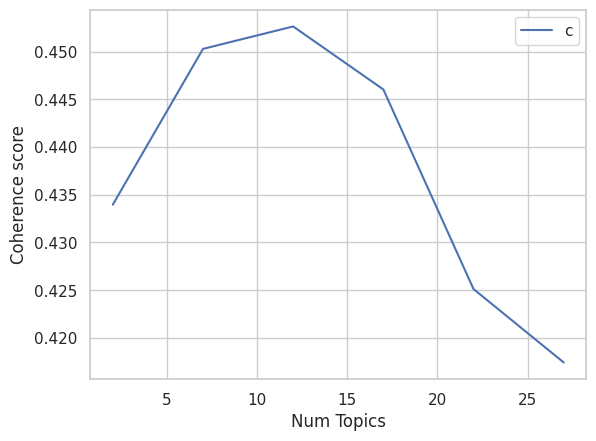

In [119]:
# -*- coding: utf-8 -*-
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


def find_optimal_number_of_topics(dictionary, corpus, processed_data):
    limit = 30;
    start = 2;
    step = 5;

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

if __name__ == '__main__':
    #processed_data = [sent.strip().split(",") for sent in tqdm(open('./data/tokenized_data.csv', 'r', encoding='utf-8').readlines())]

    # 정수 인코딩과 빈도수 생성
    dictionary = corpora.Dictionary(processed_data)

    # 출현빈도가 적거나 자주 등장하는 단어는 제거
    # no_below: 적어도 n개 이상의 문서에서 등장해야함
    # no_above: n% 이상의 문서에서 등장하면 배제함.

    dictionary.filter_extremes(no_below=10, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in processed_data]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    # 최적의 토픽 수 찾기
    find_optimal_number_of_topics(dictionary, corpus, processed_data)


In [ ]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


if __name__ == '__main__':
    #processed_data = [sent.strip().split(",") for sent in tqdm(open('./data/tokenized_data.csv', 'r', encoding='utf-8').readlines())]

    # 정수 인코딩과 빈도수 생성
    dictionary = corpora.Dictionary(processed_data)

    # 출현빈도가 적거나 자주 등장하는 단어는 제거
    dictionary.filter_extremes(no_below=10, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in processed_data]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    # 최적의 토픽 수 찾기 => 14개로 나옴
    # find_optimal_number_of_topics(dictionary, corpus, processed_data)
    # exit()

    perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
    coherence_logger = CoherenceMetric(corpus=corpus, coherence="u_mass", logger='shell')

    lda_model = LdaModel(corpus, id2word=dictionary, num_topics=12, passes=30, callbacks=[coherence_logger, perplexity_logger])

    topics = lda_model.print_topics(num_topics=12, num_words=10) #단어 개수 선정

    topic_dict = {}
    for topic in topics:
      topic_num, topic_words = topic
      words_proba = [word.split("*") for word in topic_words.split(" + ")]
      # 비율이 가장 높은 단어를 토픽으로 선정
      max_proba_word = max(words_proba, key=lambda x: float(x[0]))[1].replace('"', '')
      topic_dict[topic_num] = max_proba_word

    print(topic_dict)
    # 각 문서에 대한 토픽 할당
   #doc_topic_assignments = []
    #for doc_bow in corpus:
    #    topic_distribution = lda_model.get_document_topics(doc_bow)
    #    assigned_topic = max(topic_distribution, key=lambda x: x[1])[0]  # 가장 확률이 높은 토픽 선택
    #    doc_topic_assignments.append(assigned_topic)

    # 토픽 할당 값을 DataFrame에 추가
    #df['토픽_할당'] = doc_topic_assignments




    # Compute Coherence Score using c_v
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_data, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score (c_v): ', coherence_lda)


Number of unique tokens: 101
Number of documents: 1076
{0: '급등', 1: '증상', 2: '질병', 3: '관련주', 4: '진단', 5: '테마', 6: '비상사태', 7: '확산', 8: '주식', 9: '코로나', 10: '주가', 11: '국내'}

Coherence Score (c_v):  0.42914398479839383


In [ ]:
len(topic_dict)

12

In [ ]:
for i, topic_list in enumerate(lda_model[corpus]):
    if i==5: #일단 5개만 확인
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(0, 0.041666742), (1, 0.041666742), (2, 0.041666742), (3, 0.041666742), (4, 0.041666742), (5, 0.5416645), (6, 0.041666742), (7, 0.041666742), (8, 0.041666742), (9, 0.041668065), (10, 0.041666742), (11, 0.041666742)]
1 번째 문서의 topic 비율은 [(0, 0.0416667), (1, 0.0416667), (2, 0.0416667), (3, 0.0416667), (4, 0.0416667), (5, 0.0416667), (6, 0.54166627), (7, 0.0416667), (8, 0.0416667), (9, 0.0416667), (10, 0.0416667), (11, 0.0416667)]
2 번째 문서의 topic 비율은 [(0, 0.020833444), (1, 0.020833444), (2, 0.26958647), (3, 0.020833444), (4, 0.020833444), (5, 0.27083176), (6, 0.0208335), (7, 0.2720801), (8, 0.020833444), (9, 0.020834077), (10, 0.020833444), (11, 0.020833444)]
3 번째 문서의 topic 비율은 [(0, 0.083333336), (1, 0.083333336), (2, 0.083333336), (3, 0.083333336), (4, 0.083333336), (5, 0.083333336), (6, 0.083333336), (7, 0.083333336), (8, 0.083333336), (9, 0.083333336), (10, 0.083333336), (11, 0.083333336)]
4 번째 문서의 topic 비율은 [(0, 0.0416667), (1, 0.0416667), (2, 0.54166627), (3, 0.0416

## LDA모델 결과 df로 저장

In [ ]:
issue='원숭이두창'
#issue = 'N번방'


In [ ]:
# DataFrame 생성
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
df_results = pd.DataFrame(columns=['토픽 번호', '대표 단어', '대표 단어 확률','튜플 리스트'])

# DataFrame에 데이터 추가
for doc_num, topic_list in enumerate(lda_model[corpus]):
    if doc_num==1:
      break
    for topic_id, weight in topic_list:
        rep_word, word_prob = lda_model.show_topic(topic_id)[0]
        df_results = df_results.append({
            '토픽 번호': topic_id,
            '대표 단어': rep_word,
            '대표 단어 확률': word_prob,
            '튜플 리스트': lda_model.show_topic(topic_id)
        }, ignore_index=True)

# 결과 출력
print(df_results)
LDA_Topic_list=df_results


#csv 저장
LDA_Topic_list.to_csv('/content/drive/MyDrive/2023 겨울계절 URP/데이터_수집/토픽모델링결과/{}_LDA_Topic_list_{}_df_유튜브.csv'.format(issue,timestamp),encoding='utf-8-sig',index=False)

   토픽 번호 대표 단어  대표 단어 확률                                             튜플 리스트
0      0    급등  0.215720  [(급등, 0.21571974), (관련주, 0.15313779), (롤러코스터, ...
1      1    증상  0.142669  [(증상, 0.14266932), (감염, 0.13859892), (백신, 0.11...
2      2    질병  0.167229  [(질병, 0.1672287), (매수, 0.13101767), (상한가, 0.10...
3      3   관련주  0.496022  [(관련주, 0.4960219), (대응, 0.073974386), (증시, 0.0...
4      4    진단  0.157716  [(진단, 0.15771554), (매매, 0.10088957), (사료, 0.09...
5      5    테마  0.247431  [(테마, 0.24743143), (이유, 0.13215621), (재건, 0.08...
6      6  비상사태  0.169928  [(비상사태, 0.16992775), (시작, 0.15220301), (간염, 0....
7      7    확산  0.165490  [(확산, 0.16548972), (세계, 0.13805188), (특징, 0.07...
8      8    주식  0.209108  [(주식, 0.20910762), (분석, 0.1530974), (종목, 0.120...
9      9   코로나  0.266499  [(코로나, 0.26649907), (백신, 0.21498159), (바이러스, 0...
10    10    주가  0.323376  [(주가, 0.32337633), (전망, 0.28582838), (관련주, 0.0...
11    11    국내  0.213580  [(국내, 0.21358009), (확진자, 0.08721365), (의심, 0.0...


<ipython-input-55-fb2b502e8225>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
<ipython-input-55-fb2b502e8225>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
<ipython-input-55-fb2b502e8225>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
<ipython-input-55-fb2b502e8225>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = df_results.append({
<ipython-input-55-fb2b502e8225>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_results = 

In [ ]:
'''
for i, topic_list in enumerate(lda_model[corpus]):
    if i==1: # 일단 5개만 확인
        break
    print(i, '번째 문서의 topic 비율은', topic_list)

    # 각 주제의 상위 단어와 가중치 출력
    for topic_id, weight in topic_list:
        print(f"Topic {topic_id}:")
        print(lda_model.show_topic(topic_id))  # 해당 주제의 상위 단어 출력
        print("------")
        '''


'\nfor i, topic_list in enumerate(lda_model[corpus]):\n    if i==1: # 일단 5개만 확인\n        break\n    print(i, \'번째 문서의 topic 비율은\', topic_list)\n\n    # 각 주제의 상위 단어와 가중치 출력\n    for topic_id, weight in topic_list:\n        print(f"Topic {topic_id}:")\n        print(lda_model.show_topic(topic_id))  # 해당 주제의 상위 단어 출력\n        print("------")\n        '

In [ ]:
'''
for i, topic_list in enumerate(lda_model[corpus]):
    if i==5: # 일단 5개만 확인
        break
    print(i, '번째 문서의 topic 비율은', topic_list)
'''

"\nfor i, topic_list in enumerate(lda_model[corpus]):\n    if i==5: # 일단 5개만 확인\n        break\n    print(i, '번째 문서의 topic 비율은', topic_list)\n"

# 저장하기 위한 df정리

In [ ]:
def make_topictable_per_doc(lda_model, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(lda_model[corpus]):
        doc = topic_list[0] if lda_model.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%),
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)


In [ ]:
topic_table=make_topictable_per_doc(lda_model, corpus)

<ipython-input-58-a435ce19ffd3>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
<ipython-input-58-a435ce19ffd3>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
<ipython-input-58-a435ce19ffd3>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
<ipython-input-58-a435ce19ffd3>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

In [ ]:
def make_topictable_per_doc(lda_model, corpus, topic_dict):
    topic_table = pd.DataFrame()

    for i, topic_list in enumerate(lda_model[corpus]):
        doc = topic_list[0] if lda_model.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:
                # 가장 비중이 높은 토픽의 대표 단어를 가져옵니다.
                topic_word = topic_dict.get(topic_num, f"Unknown_{topic_num}")
                new_row = pd.Series([topic_word, round(prop_topic, 4), topic_list])
                topic_table = pd.concat([topic_table, new_row.to_frame().T], ignore_index=True)
            else:
                break
    return topic_table


In [ ]:
topic_table = make_topictable_per_doc(lda_model, corpus, topic_dict)

각 문서에 기여한 토픽이 있고 다시 그 토픽 안에 기여된 단어들이 있으므로 가장 비율이 높은 토픽의 가장 비율이 높은 단어를 할당해야함

In [ ]:
print(topic_table)

         0       1                                                  2
0       테마  0.5417  [(0, 0.04166674), (1, 0.04166674), (2, 0.04166...
1     비상사태  0.5417  [(0, 0.0416667), (1, 0.0416667), (2, 0.0416667...
2       확산  0.2721  [(0, 0.020833442), (1, 0.020833442), (2, 0.269...
3       급등  0.0833  [(0, 0.083333336), (1, 0.083333336), (2, 0.083...
4       질병  0.5417  [(0, 0.0416667), (1, 0.0416667), (2, 0.5416662...
...    ...     ...                                                ...
1071    테마  0.5417  [(0, 0.041666742), (1, 0.041666742), (2, 0.041...
1072  비상사태  0.5417  [(0, 0.041666705), (1, 0.041666705), (2, 0.041...
1073    테마  0.3611  [(0, 0.027778305), (1, 0.027777962), (2, 0.027...
1074    질병  0.3611  [(0, 0.3611101), (1, 0.027777867), (2, 0.36111...
1075    주식  0.5417  [(0, 0.04166709), (1, 0.041666694), (2, 0.0416...

[1076 rows x 3 columns]


In [ ]:
#인덱스는 문서번호
import pandas as pd

def make_topictable_per_doc(lda_model, corpus, topic_dict):
    topic_table = pd.DataFrame()

    for i, topic_list in enumerate(lda_model[corpus]):
        doc = topic_list[0] if lda_model.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(doc):
            if j == 0:
                # 가장 비중이 높은 토픽의 대표 단어를 가져옵니다.
                topic_word = topic_dict.get(topic_num, f"Unknown_{topic_num}")
                topic_table = topic_table.append(pd.Series([topic_word, round(prop_topic, 4), topic_list]), ignore_index=True)
            else:
                break
    return topic_table


result_table = make_topictable_per_doc(lda_model, corpus, topic_dict)
result_table[2] = result_table[2].apply(lambda x: [(topic_dict.get(topic, f"Unknown_{topic}"), prob) for topic, prob in x])
#print(result_table)


<ipython-input-63-7f53d428fac7>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([topic_word, round(prop_topic, 4), topic_list]), ignore_index=True)
<ipython-input-63-7f53d428fac7>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([topic_word, round(prop_topic, 4), topic_list]), ignore_index=True)
<ipython-input-63-7f53d428fac7>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topic_table = topic_table.append(pd.Series([topic_word, round(prop_topic, 4), topic_list]), ignore_index=True)
<ipython-input-63-7f53d428fac7>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

In [ ]:
#df1=news_all[['link',	'작성날짜',	'제목',	'언론사',	'댓글수',	'nouns']]
df1=news_all
df2=topic_table
df3=result_table


In [ ]:
df1=df1.reset_index(drop=True)


In [ ]:
result = pd.concat([df1, df2,df3[2]], axis=1, ignore_index=True)

In [ ]:
result = result.rename(columns={
    0: 'Date',
  1: 'Channel',
    2: 'Title',
    3: 'View_Count',
    4: 'Month',
    5: 'Day',
    6: 'Year',
    7: 'nouns',
    8: 'topic',
    9: 'probability',
    10: 'topicNum_N_prob',
    11: 'topicWord_N_prob'
})


In [ ]:
result['Date'] = pd.to_datetime(result['Date'])

# Sort the DataFrame by date
result = result.sort_values(by='Date')

# Reset the index
result = result.reset_index(drop=True)

# Print the updated DataFrame
print(result)

           Date                    Channel  \
0    2022-05-02                   캐나다 자막뉴스   
1    2022-05-04                   키움증권 채널K   
2    2022-05-04                       지식한끼   
3    2022-05-05                       아싸도도   
4    2022-05-10                       우주포탈   
...         ...                        ...   
1071 2022-07-31  Economic news 읽어주는 여자 이코녀   
1072 2022-07-31                      ANHTV   
1073 2022-07-31                     주식 에너지   
1074 2022-07-31                   마스터 알렉스권   
1075 2022-07-31                     영어뉴스청취   

                                                  Title  View_Count  Month  \
0         캐나다, 동성애자 헌혈 금지 폐지 (캐나다)         149   2022   
1     [2022 키움 방송] - ‘하루에 1,500만 원 수익 내는 24살 천재 대학생_...      457512   2022   
2                                   수두백신 2차접종 꼭 해야 하나요?         583   2022   
3        [#VLOG] :: 왜요 제가 시험기간에 유튜브나 찍는 사람으로 보이시나요? (맞음          66   2022   
4     원인불명 어린이 급성 간염확산/원숭이 원숭이두창 발생/김지하 시인별세 증산사상에 인...  

In [ ]:
result

,Date,Channel,Title,View_Count,Month,Day,Year,nouns,topic,probability,topicNum_N_prob,topicWord_N_prob
0,2022-05-02,캐나다 자막뉴스,"캐나다, 동성애자 헌혈 금지 폐지 (캐나다)",149,2022,5,2,"[캐나다, 동성애자, 헌혈, 금지, 폐지, 캐나다]",급등,0.0833,"[(0, 0.083333336), (1, 0.083333336), (2, 0.083...","[(급등, 0.083333336), (증상, 0.083333336), (질병, 0...."
1,2022-05-04,키움증권 채널K,"[2022 키움 방송] - ‘하루에 1,500만 원 수익 내는 24살 천재 대학생_...",457512,2022,5,4,"[키움, 다큐, 하루, 수익, 천재, 대학생, 스캘핑, 천재]",관련주,0.5417,"[(0, 0.04166676), (1, 0.04166676), (2, 0.04166...","[(급등, 0.04166676), (증상, 0.04166676), (질병, 0.04..."
2,2022-05-04,지식한끼,수두백신 2차접종 꼭 해야 하나요?,583,2022,5,4,"[수두, 백신, 접종]",증상,0.6944,"[(0, 0.027777834), (1, 0.6944422), (2, 0.02777...","[(급등, 0.027777834), (증상, 0.6944422), (질병, 0.02..."
3,2022-05-05,아싸도도,[#VLOG] :: 왜요 제가 시험기간에 유튜브나 찍는 사람으로 보이시나요? (맞음,66,2022,5,5,"[시험, 기간, 유튜브, 사람]",급등,0.0833,"[(0, 0.083333336), (1, 0.083333336), (2, 0.083...","[(급등, 0.083333336), (증상, 0.083333336), (질병, 0...."
4,2022-05-10,우주포탈,원인불명 어린이 급성 간염확산/원숭이 원숭이두창 발생/김지하 시인별세 증산사상에 인...,499,2022,5,10,"[원인, 불명, 어린이, 급성, 간염, 확산, 김지하, 시인, 별세, 증산, 사상,...",확산,0.5208,"[(0, 0.02083346), (1, 0.020834712), (2, 0.0208...","[(급등, 0.020833462), (증상, 0.020835022), (질병, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
1071,2022-07-31,Economic news 읽어주는 여자 이코녀,[The Korea Herald] Apartment transactions plun...,12,2022,7,31,[],급등,0.0833,"[(0, 0.083333336), (1, 0.083333336), (2, 0.083...","[(급등, 0.083333336), (증상, 0.083333336), (질병, 0...."
1072,2022-07-31,ANHTV,"베트남, 원숭이원숭이두창 감염자·의심환자 격리…방역지침 발표 | 베트남 뉴스",361,2022,7,31,"[베트남, 감염자, 의심, 환자, 격리, 방역, 지침, 발표, 베트남]",국내,0.6944,"[(0, 0.027777836), (1, 0.027777836), (2, 0.027...","[(급등, 0.027777836), (증상, 0.027777836), (질병, 0...."
1073,2022-07-31,주식 에너지,"노터스 ""8월 하늘문재인 개방, 주가 승천 112%"" 지금 사면 대박 난다! 8/1...",793,2022,7,31,"[하늘문, 개방, 주가, 승천, 사면, 매매, 전략]",진단,0.5208,"[(0, 0.020833392), (1, 0.020833392), (2, 0.020...","[(급등, 0.020833392), (증상, 0.020833392), (질병, 0...."
1074,2022-07-31,마스터 알렉스권,"온라인교육, 폴더블, 원숭이원숭이두창 관련주 롤러코스터 예상됨 2022 08 01",87,2022,7,31,"[온라인, 교육, 관련주, 롤러코스터, 예상됨]",급등,0.6944,"[(0, 0.69444036), (1, 0.027777808), (2, 0.0277...","[(급등, 0.69444084), (증상, 0.02777781), (질병, 0.02..."


In [ ]:
issue='원숭이두창'
#issue='n번방'



In [ ]:
#media='네이버'
media='유튜브'

In [ ]:
#csv 저장
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
result.to_csv('/content/drive/MyDrive/2023 겨울계절 URP/데이터_수집/토픽모델링결과/{}_{}_{}_topicmodeling_df_{}.csv'.format(issue,media,most_common_year,timestamp),encoding='utf-8-sig',index=False)